## Things to think about
- Are all the images the same size?
- How do I rescale the images? To what size?
- Should rescaling be done on the fly, possibly using the keras image loading thingy?
- I need to rasterize all the training WKT files
    - Must first have decided on an image size above
    - Store all 20 channels in a single 3D array
- Image sizes:
    - If I resize, is the smallest size too small to generate meaningful polygons from the raster image?
    - If I don't resize, the raster generated by the network will be a different size each time. Thus, in order to find the cost, the train raster will have to match. Can I generate a unique train raster every time? Is this computationally inefficient
    - If the files are all resized, I could probably load the training data into memory
- Need to rasterize all the training labels

In [4]:
%reset
import zipfile # for accessing zip file
import tifffile as tiff # opens tiff file
import pandas as pd
import numpy as np
from shapely import wkt # used for loading the wkt values
from shapely.affinity import scale # scales the wkt values using the description in the tutorial
from shapely.geometry import MultiPolygon
from shapely.ops import cascaded_union
import rasterio # used for rasterizing the WKT values into arrays for the final step
from rasterio.features import rasterize,shapes
from skimage.transform import resize
from skimage.external import tifffile
from skimage.io import concatenate_images
import os
import pickle

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
# Load the components of the pushbullet API

from pushbullet import Pushbullet
with open('../pushbullet.api','r') as f:
    api = f.readline().strip()   
pb = Pushbullet(api)
phone = pb.devices[0]

In [6]:
# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [7]:
train_wkt = pd.read_csv('./data/train_wkt_v4.csv',names=['imageID','feature','wkt'],skiprows=1)
grid_sizes = pd.read_csv('./data/grid_sizes.csv',names=['imageID','xmax','ymin'],skiprows=1)

In [8]:
# These variables will be used throughout

img_h = 136 # thinking about using 252 here...
img_w = 136

In [ ]:
'''
# This code extracts and resizes the images from the sixteen_band zipfile

# More recent version, uses skimage entirely
# Hasn't been run fully yet, doesn't work though

with zipfile.ZipFile('./data/sixteen_band.zip','r') as z:
    for file in z.namelist():
        if file[-5]=='A':
            image = tifffile.imread(z.extract(file))
            image = resize(image, (image.shape[0],136,136))
            #print(file,image.shape)
        elif file[-5]=='M':
            image = tifffile.imread(z.extract(file))
            image = resize(image, (image.shape[0],136,136))
            #print(file,image.shape)
        elif file[-5]=='P':
            image = tifffile.imread(z.extract(file))
            image = resize(image,(136,136))
            #print(file,image.shape)
        else:
            print("File name was not standard: %s" %file)
    
    tifffile.imsave('./data/'+file,image)
    
'''

In [10]:
# Extract, resize and save all the images to a folder
# Sixteen band

with zipfile.ZipFile('./data/sixteen_band.zip','r') as z:
    for file in z.namelist():
        with tiff.TiffFile(z.extract(file)) as image:
            if file[-5]=='A':
                image = image.asarray()
                image = resize(image, (image.shape[0], img_h, img_w))
                
            elif file[-5]=='M':
                image = image.asarray()
                image = resize(image, (image.shape[0], img_h, img_w))
                
            elif file[-5]=='P':
                image = image.asarray()
                image = resize(image,(img_h, img_w))
                
            else:
                print("File name was not standard: %s" %file)
            tifffile.imsave('./data/combined/'+file[-14:],image)

push('Extraction and resizing done')

In [11]:
# Extract, resize and save all the images to a folder
# Three band

with zipfile.ZipFile('./data/three_band.zip','r') as z:
    for file in z.namelist():
        with tiff.TiffFile(z.extract(file,'./data/')) as image:
            image = image.asarray()
            image = resize(image,(image.shape[0], img_h, img_w))
            tifffile.imsave('./data/combined/'+file[-12:-4]+'_R.tif',image)

push('Extraction and resizing done')

### Making combined images
Currently, `./data/combined/` contains all resized images.
Simply loop through directory and append to list for full 20-channel image.

In [12]:
# concatenate the images into a single array
# Then save into one tiff image
# This includes RBG images!!

for imageID in train_wkt.imageID.unique():
    with tiff.TiffFile('./data/combined/'+ imageID +'_A'+'.tif') as image:
        A = image.asarray()
    with tiff.TiffFile('./data/combined/'+ imageID +'_M'+'.tif') as image:
        M = image.asarray()
    with tiff.TiffFile('./data/combined/'+ imageID +'_P'+'.tif') as image:
        P = image.asarray()
        P = P[np.newaxis,:,:]
    with tiff.TiffFile('./data/combined/'+ imageID +'_R'+'.tif') as image:
        R = image.asarray()
    channels = np.concatenate([R,A,M,P],axis=0)
    tifffile.imsave('./data/combined/' + imageID + '_all' + '.tif',np.array(channels))

push('Combining images is done!')

### Make training data

#### First we make the y values
Loop through all imageIDs in `train_wkt_v4`, get the WKT data and feed to `rasterio.features.raster()` to generate numpy arrays of 1's and 0's - raster versions of the WKT files for training the neural network.

In [13]:
# Generate numpy array with all training rasters
# These are the y values!

width_prime = img_w*(img_w / (img_w + 1))
height_prime = img_h*(img_h / (img_h + 1))

y = []

for imageID in train_wkt.imageID.unique():
    rasters = []
    
    xmax = grid_sizes.loc[grid_sizes.imageID==imageID].xmax.values[0]
    ymin = grid_sizes.loc[grid_sizes.imageID==imageID].ymin.values[0]
    
    image_wkt = train_wkt[train_wkt.imageID == imageID]
    
    for feature in image_wkt.feature.unique():
        polygon = wkt.loads(image_wkt[image_wkt.feature == feature].wkt.values[0])
        polygon = scale(polygon,xfact=width_prime/xmax, yfact=height_prime/ymin,origin=(0,0))
        if str(polygon) == 'MULTIPOLYGON EMPTY':
            rasters.append(np.zeros((img_w, img_h), dtype='float32'))
        else:
            '''
            rasters.append(np.flipud(rasterize(polygon, out_shape=(136,136),all_touched=True)))
            This was removed because the training data was upsidedown, despite the fact that it works below
            '''
            rasters.append(rasterize(polygon, out_shape=(img_w, img_h),all_touched=True))
    
    y.append(rasters)
    
y = np.array(y)
print(y.shape) # Should be (25, 10, img_w, img_h)

(25, 10, 136, 136)


In [14]:
# Pickle the data!

with open('./data/y_resized_raster.pickle','wb') as f:
    pickle.dump(y,f,pickle.HIGHEST_PROTOCOL)

In [15]:
push('y array is done')

#### Second, we generate the x values
We load each image file in the /combined folder and save them to numpy arrays

In [16]:
# concatenate the images into a single array

x = []
for imageID in train_wkt.imageID.unique():
    for file in os.listdir('./data/combined'):
        if file.startswith(imageID) & file.endswith('_all.tif'):
            with tiff.TiffFile('./data/combined/'+file) as image:
                image = image.asarray()
                x.append(image)
x = np.array(x)
print(x.shape) # Should be (25,20,img_w,img_h)
push('x array is done')

(25, 20, 136, 136)


In [17]:
# This function performs ZCA whitening on the data

def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1 #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T) #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs) #Data whitening

In [18]:
# Here we send the x array to the ZCA whitening function and save the result in a new array

x_whitened = np.empty(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x_whitened[i,j,:,:] = zca_whitening(x[i,j,:,:].reshape(-1,img_h*img_w)).reshape(img_h,img_w)

In [19]:
# Pickle the data!

with open('./data/x_resized_array.pickle','wb') as f:
    pickle.dump(x,f,pickle.HIGHEST_PROTOCOL)
    
with open('./data/x_whitened_resized_array.pickle','wb') as f:
    pickle.dump(x_whitened,f,pickle.HIGHEST_PROTOCOL)

- For each image in the dataset:
    - open the file
    - concatenate the channels into a single array
    - resave the file

### Generating submissions

In [3]:
# These are the images that should be predicted on in order to make a submission

submission = {}
for imageID in grid_sizes.imageID.unique():
    for file in os.listdir('./data/combined'):
        if file.startswith(imageID):
            with tiff.TiffFile('./data/combined/'+file) as image:
                image = image.asarray()
                submission[imageID] = image
#submission = np.array(submission)

In [4]:
# Pickle the data!

with open('./data/submission_resized_array.pickle','wb') as f:
    pickle.dump(submission,f,pickle.HIGHEST_PROTOCOL)

### Code for converting raster images back to polygons
This code will be used after predicting a submission, in order to generate polygons for submission

In [ ]:
# This code makes polygons from the raster image
# This will eventually be used to convert the heatmaps from the CNN to polygons for submission
mask = raster != 0
imputed_polygons = shapes(raster, mask=mask)
imputed_image = rasterize(((g, 255) for g, v in imputed_polygons),out_shape=(image.shape[-1],image.shape[-2]))

In [18]:
# This is for converting single image co-ordinates into global co-ordinates that match the WKT information
# Here, we execute for just a single example: imageID 6100_1_3

width_prime = image.shape[-1]*(image.shape[-1]/(image.shape[-1]+1))
height_prime = image.shape[-2]*(image.shape[-2]/(image.shape[-2]+1))
xmax = grid_sizes.loc[grid_sizes.imageID=='6100_1_3'].xmax.values[0]
ymin = grid_sizes.loc[grid_sizes.imageID=='6100_1_3'].ymin.values[0]

In [16]:
# This cell gets the WKT information from train_wkt and loads each feature into a dict of polygons
# Again, this is done for a single imageID: 6100_1_3
polygons = {}
image_wkt = train_wkt[train_wkt.imageID == '6100_1_3']
for feature in image_wkt.feature.unique():
    polygons[feature] = wkt.loads(image_wkt[image_wkt.feature == feature].wkt.values[0])

In [19]:
# This code scales the polygons by the factors calculated above for this imageID
scaled_polygon = scale(polygons[5],xfact=width_prime/xmax, yfact=height_prime/ymin,origin=(0,0))

In [20]:
# This code makes a raster image from the scaled polygon
# Note: this tended to be upsidedown, hence the np.flipud.
# However, the data was not upsidedown when it got to training so this isn't used later to generate training data

raster = np.flipud(rasterize(scaled_polygon, out_shape=(image.shape[-1],image.shape[-2]),all_touched=True))

In [ ]:
# This code makes polygons from a raster image
# This will eventually be used to convert the heatmaps from the CNN to polygons for submission

mask = raster != 0
imputed_polygons = shapes(raster, mask=mask)
imputed_image = rasterize(((g, 255) for g, v in imputed_polygons),out_shape=(image.shape[-1],image.shape[-2]))

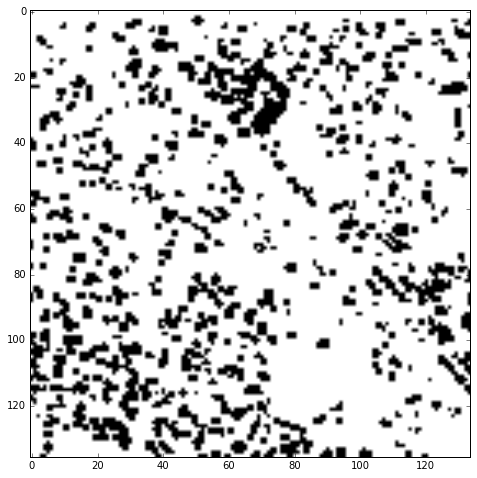

In [66]:
# Here we plot the raster that was generated

from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(raster,cmap='Greys')
plt.show()

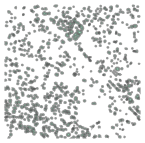

In [38]:
# This code displays a small image directly from the polygons
# It should match the figure plotted above
scale(polygons[5],xfact=width_prime/xmax, yfact=height_prime/ymin,origin=(0,0))